In [2]:
! nvidia-smi
! nvcc -V

Sat Mar  9 13:37:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.103                Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        On  | 00000000:09:00.0  On |                  N/A |
|  0%   30C    P8              18W / 170W |   1010MiB / 12288MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os
import sys
import gc
import numpy as np
import torch
from torchsummary import summary
from torch.cuda.amp import GradScaler, autocast
from utils import accuracy_cafe, accuracy_fer, accuracy_res, setup_seed, latent_space, manifold_sphere, reconstruction, latent_sample, EarlyStopping
from train import train
from transfer import transfer
from finetune import finetune
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import pi

from dataset_cafe import get_cafeloaders
from dataset_jaffe import get_jaffeloaders
from dataset_fer2013 import get_dataloaders
import models
from torchvision.transforms import Resize

In [4]:
class config:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # distribution_id = 'normal' # or normal
    distribution_emo = 'normal' # or normal
    # latent_dim_id = 2  # determine shape of latent space, 2 or 3
    latent_dim_emo = 2  # determine shape of latent space, 2 or 3
    radius = 1  #controlling the radius of the hypersphere or the gaussian
    kappa = 300  # enough details but not too much, set as 500 according to the area of recontructive sampling

    data_path = "./data/cafe/balance_all"  # "./data/jaffe"
    image_size = (64, 40)  # determine the raw size before transform: (40, 40) or (64, 40) or (48, 40)
    label_list = {'0':'Angry', '1':'Disgust', '2':'Fear', '3':'Happy', '4':'Sad', '5':'Surprise', '6':'Neutral'}

    weight_recon = 0.2 #  1 - alpha
    # weight_class_id = 0  # weight of classfier loss
    weight_class_emo = 1 - weight_recon
    
    aug = False
    Ncrop = False 
    if Ncrop:
        batchsize = 16  # with Ncrop = 5
    elif not Ncrop:
        batchsize = 128
    else:
        raise NotImplemented
    
    loss = torch.nn.MSELoss  
    # "MSELoss" or "BCEWithLogitsLoss", when use BCEWithLogitsLoss, sigmoid af in the end of decoder should be removed!!
    n_epoch = 200
    transfer_epoch = 200
    learning_rate = 1e-3
    scheduler = None  # learning rate schedule, "reduce", None ...
    saved_path = "./saved_models/"
    
print(config.device)
setup_seed(1)

cuda


In [49]:
# data
# Kfold = "3/5"
# valid_loader = get_jaffeloaders(path=config.train_path, 
#                                bs=config.batchsize, 
#                                augment=config.aug, input_size=config.image_size)
train_loader = get_cafeloaders(path=config.data_path, 
                               bs=config.batchsize, 
                               augment=config.aug, input_size=config.image_size, 
                               k_fold=None)
_, valid_loader, test_loader = get_dataloaders(path='data/fer2013/fer2013.csv', bs=128)

### Try VGG first

In [14]:
model = models.Vgg()
checkpoint = torch.load("models/VGGNet")
model.load_state_dict(checkpoint['params'])
model = model.to(config.device)

In [15]:
model.eval()
positive_pred = 0
amount = 0

for data in train_loader: 
    base_images, base_images_id, labels, labels_id = data
    
    base_images, labels= base_images.to(config.device), labels.to(config.device)
    # base_images_id, labels_id= base_images_id.to(config.device), labels_id.to(config.device)
    
    labels_emo_ = model(Resize((40, 40))(base_images))
    positive_pred += torch.sum(torch.argmax(labels_emo_, dim=1, keepdim=False) == labels)
    amount += len(labels)

accuracy = positive_pred.cpu().numpy() / amount
accuracy

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.14166666666666666

### combine the resnet

In [4]:
resnet18 = models.ResNet18()
# print(resnet18)
checkpoint = torch.load("models/best_checkpoint.tar")  # best_checkpoint.tar
# model.load_state_dict(checkpoint['params'])
resnet18.load_state_dict(checkpoint['model_state_dict'])
resnet18 = resnet18.to(config.device)

vae = models.VAE(z_dim=config.latent_dim_emo,
                 distribution=config.distribution_emo,
                 kappa=config.kappa, 
                 radius=config.radius, 
                 device=config.device).to(config.device)

In [6]:
accuracy_res(resnet18, test_loader, config, size=(40, 40))

0.7241571468375592

In [7]:
class resVAE(torch.nn.Module):
    def __init__(self, submodel1, submodel2):
        super(resVAE, self).__init__()
        self.submodel1 = submodel1
        self.submodel2 = submodel2
 
    def forward(self, x):
        _, x = self.submodel1(x)
        (z_mean, z_var), (q_z, p_z), z, (x_rec, x_cla) = self.submodel2(x)
        
        return (z_mean, z_var), (q_z, p_z), z, (x_rec, x_cla)

# resnetVAE = resVAE(resnet18, vae)

### training

In [14]:
for p in resnetVAE.parameters():
    p.requires_grad = False
for i,p in enumerate(resnetVAE.parameters()):
    if i > 61:
        p.requires_grad = True
for name, param in resnetVAE.named_parameters():
    if param.requires_grad:
        print(name)

submodel2.fc_mean.weight
submodel2.fc_mean.bias
submodel2.fc_var.weight
submodel2.fc_var.bias
submodel2.fc_de0.weight
submodel2.fc_de0.bias
submodel2.fc_de1.weight
submodel2.fc_de1.bias
submodel2.Tcov_de2.weight
submodel2.Tcov_de2.bias
submodel2.Tcov_de3.weight
submodel2.Tcov_de3.bias
submodel2.Tcov_de4.weight
submodel2.Tcov_de4.bias
submodel2.linear.weight
submodel2.linear.bias


Epoch  1/200: RC_loss   6.033, KL_loss   1.671, CL_loss_emo1866.083, acc_in_fer   0.204, acc_in_cafe   0.221
Validation measure (inf --> 0.204235).  Saving model ...
Epoch  2/200: RC_loss   5.859, KL_loss   1.775, CL_loss_emo1859.376, acc_in_fer   0.259, acc_in_cafe   0.256
Validation measure (0.204235 --> 0.258568).  Saving model ...
Epoch  3/200: RC_loss   5.489, KL_loss   1.995, CL_loss_emo1852.035, acc_in_fer   0.264, acc_in_cafe   0.258
Validation measure (0.258568 --> 0.263862).  Saving model ...
Epoch  4/200: RC_loss   5.023, KL_loss   2.333, CL_loss_emo1844.887, acc_in_fer   0.264, acc_in_cafe   0.257
Epoch  5/200: RC_loss   4.581, KL_loss   2.776, CL_loss_emo1836.999, acc_in_fer   0.263, acc_in_cafe   0.257
Epoch  6/200: RC_loss   4.261, KL_loss   3.240, CL_loss_emo1830.132, acc_in_fer   0.264, acc_in_cafe   0.257
Epoch  7/200: RC_loss   4.005, KL_loss   3.804, CL_loss_emo1822.889, acc_in_fer   0.264, acc_in_cafe   0.257
Validation measure (0.263862 --> 0.264419).  Saving mode

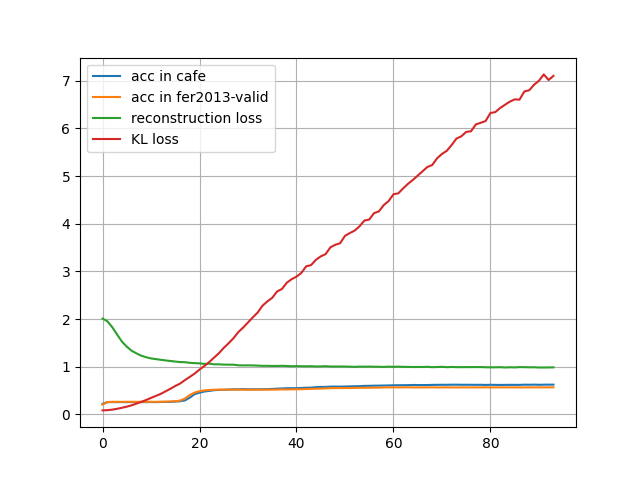

In [15]:
# optimizer
optimizer = torch.optim.Adam([p for p in resnetVAE.parameters() if p.requires_grad == True], lr=config.learning_rate, betas=(0.9, 0.99))
# amp: automatic mixed precision training 
scaler = GradScaler()  
# scheduler to adjust the learning rate
if config.scheduler == 'reduce':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=False)

# training process trend monitor
accuracy_valid = []
accuracy_train = []
reconstruction_loss = []
kl = []

earlystop = EarlyStopping(patience=30, verbose=True, path='saved_models/' + 'test.pt')

for epoch in range(config.n_epoch):
    rec_loss, kl_loss, cla_loss = train(resnetVAE, train_loader, optimizer, scaler, config) 
    
    if config.scheduler == 'reduce':
        scheduler.step(rec_loss + cla_loss/250)
        
    acc = accuracy_fer(resnetVAE, valid_loader, config)
    acc_cafe = accuracy_cafe(resnetVAE, train_loader, config)
    accuracy_valid.append(acc)
    accuracy_train.append(acc_cafe)
    reconstruction_loss.append(rec_loss.cpu().detach().numpy() / 3)
    kl.append(kl_loss.cpu().detach().numpy() / 20)

    print("Epoch%3d/%3d: RC_loss%8.3f, KL_loss%8.3f, CL_loss_emo%8.3f, acc_in_fer%8.3f, acc_in_cafe%8.3f" 
          % (epoch+1, config.n_epoch, rec_loss, kl_loss, cla_loss, acc, acc_cafe))
    # print("=====XXX=====")
    earlystop(acc, "max", resnetVAE)
    if earlystop.early_stop:
        break

    # finish the train
    # if acc_cafe > 0.685:
    #     model_name = "seed131_w55_var=1_bs128_size40.pt"
    #     torch.save(resnetVAE, config.saved_path + model_name)
    #     print("model has been saved as:", config.saved_path + model_name)
    #     break


# training process trend monitor
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(accuracy_train, label="acc in cafe")
ax.plot(accuracy_valid, label="acc in fer2013-valid")
ax.plot(reconstruction_loss, label="reconstruction loss")
ax.plot(kl, label="KL loss")
# ax.vlines(len(loss_reconstruction)-config.finetune_epoch-1, 0, 10, linestyles='dashed', colors='yellow', label="start the decoder-finetune")
plt.grid()
plt.legend()
plt.show()

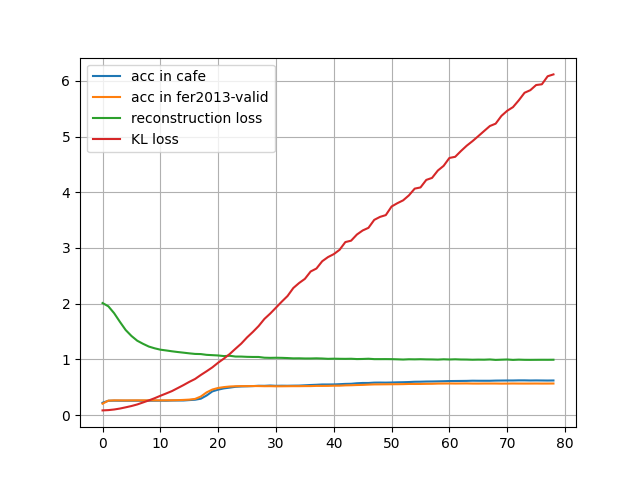

In [22]:
torch.save(resnetVAE, config.saved_path + "seed1_dim2_noKL(cafe).pt")
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(accuracy_train, label="acc in cafe")
ax.plot(accuracy_valid, label="acc in fer2013-valid")
ax.plot(reconstruction_loss, label="reconstruction loss")
ax.plot(kl, label="KL loss")
# ax.vlines(len(loss_reconstruction)-config.finetune_epoch-1, 0, 10, linestyles='dashed', colors='yellow', label="start the decoder-finetune")
plt.grid()
plt.legend()
plt.show()

### vasualization

In [8]:
model_name = "model/seed13_KL02(cafe).pt"  # "seed13_KL02(cafe) with weight of reconstryction as 0.6, seed1_dim2_noKL(cafe)"
model = torch.load("./saved_models/" + model_name)

In [6]:
class bentoVAE(torch.nn.Module):
    def __init__(self, model):
        super(bentoVAE, self).__init__()
        self.model = model
 
    def forward(self, x):
        result = self.model(x)
        
        return result

In [7]:
decoder = bentoVAE(model.submodel2.decoder)
torch.save(decoder, "./saved_models" + "/model/seed13_KL02(decoder).pt")

In [7]:
decoder = torch.load("./saved_models/" + "/model/seed13_KL02(decoder).pt")
decoder.eval()
for p in decoder.parameters():
    p.requires_grad = False

In [7]:
accuracy_fer(model, test_loader, config)

0.6271942045137922

In [8]:
accuracy_cafe(model, train_loader, config)

0.69375

Number of data: 960


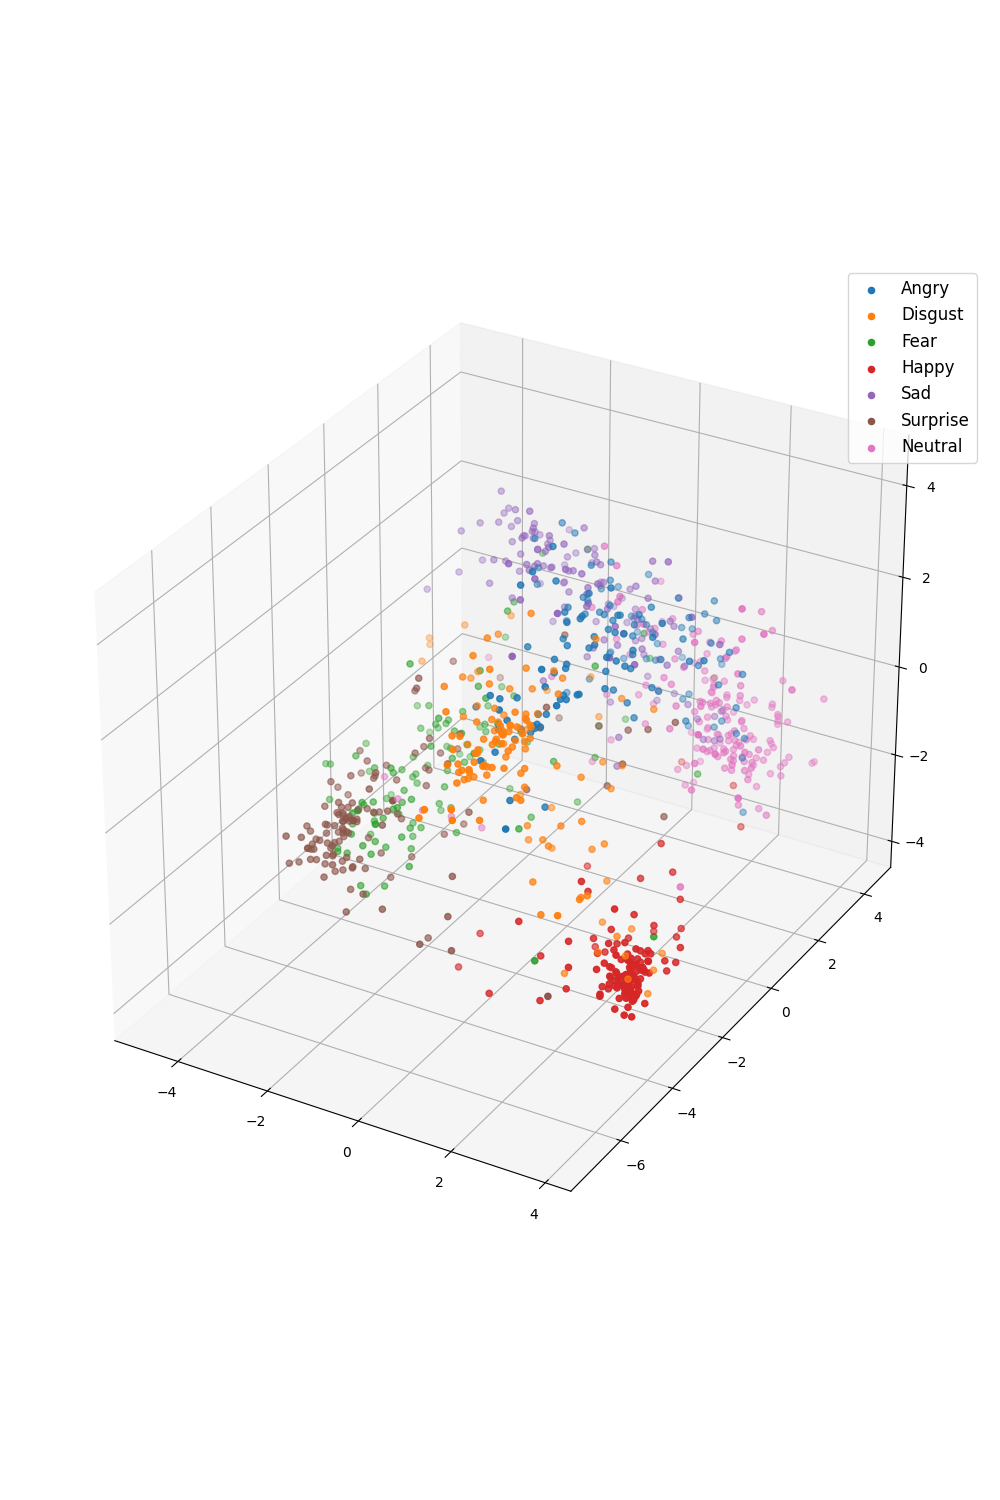

In [9]:
%matplotlib widget
latent_space(model, train_loader, config, legend=True, dataset="cafe")

In [50]:
plt.close()

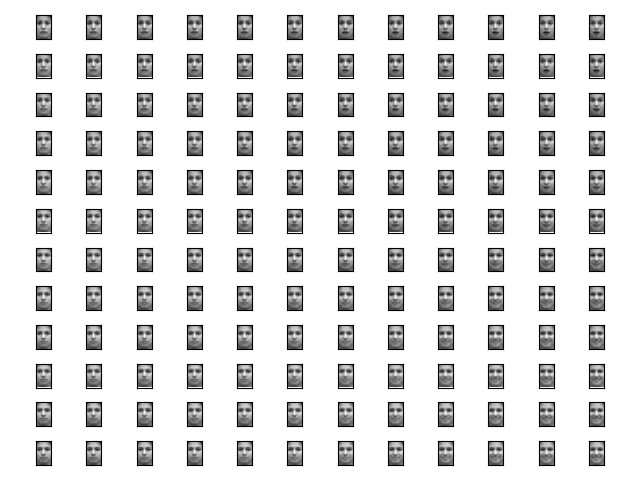

In [15]:
xy_resolution = 15
manifold_sphere(model.submodel2, config,
                theta=list(b*pi for b in np.linspace(0, 2, xy_resolution)), 
                z_resolution=12, # z_resolution works only when z_dim=3
                z=-2
               )  # theta belons to the range 0-2pi

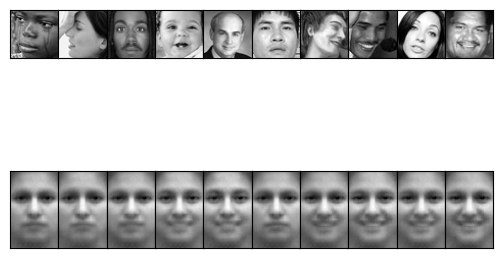

In [15]:
reconstruction(model, test_loader, n_show=10, config=config)

In [51]:
len(train_loader)

8

### Distriburion simulation

In [6]:
from hypersphere.distributions import VonMisesFisher
%matplotlib widget 

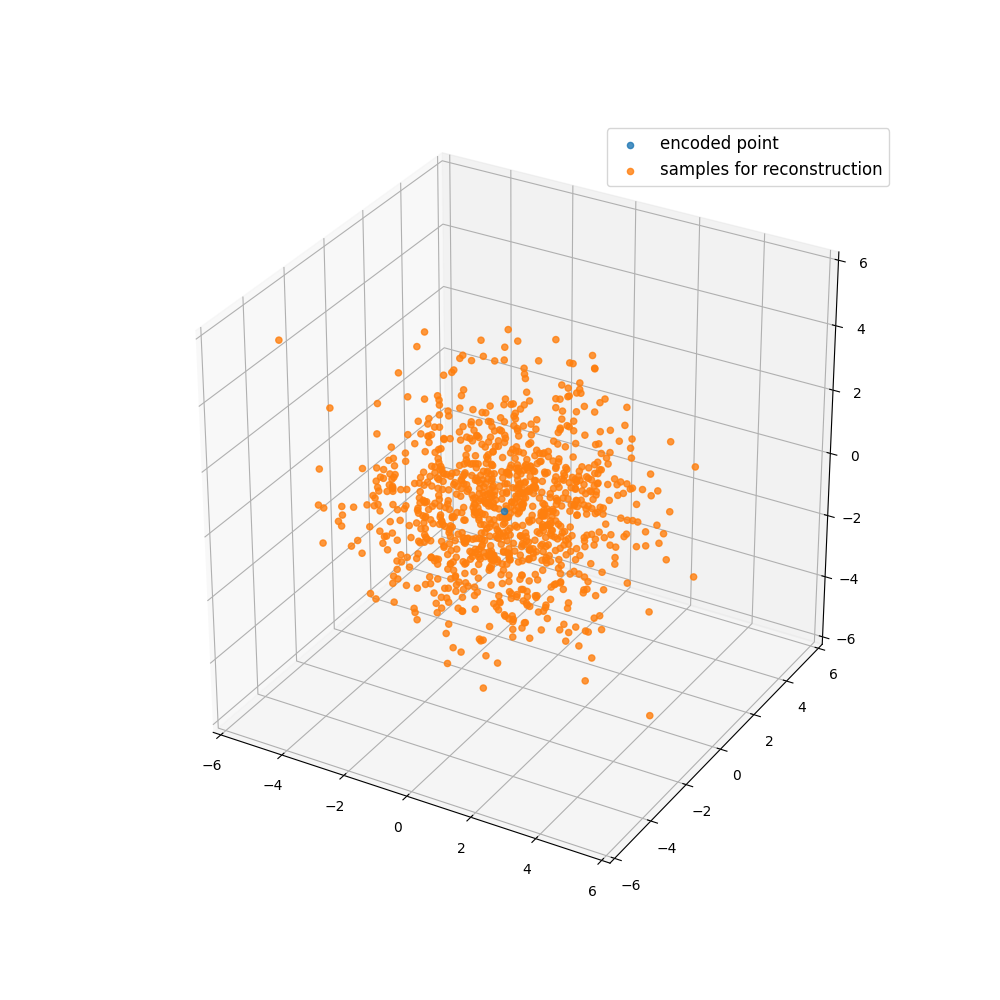

In [11]:
center = np.array([0, -1, 0])
samples = np.random.multivariate_normal(center, np.eye(3)*3, 1000)
# print(samples)
ax = plt.figure(figsize=(10, 10)).add_subplot(111, projection='3d', computed_zorder=False)

# # Make data
# u = np.linspace(0, 2 * np.pi, 100)
# v = np.linspace(0, np.pi, 100)
# x = np.outer(np.cos(u), np.sin(v))
# y = np.outer(np.sin(u), np.sin(v))
# z = np.outer(np.ones(np.size(u)), np.cos(v))

# # Plot the surface
# ax.plot_surface(x, y, z, zorder=-1, alpha=0.5, color="white")
# Set an equal aspect ratio
ax.set_aspect('equal')

ax.scatter(center[0],
           center[1],
           center[2],
           alpha=0.8, label="encoded point", zorder=999)
ax.scatter(samples[:, 0],
           samples[:, 1],
           samples[:, 2],
           alpha=0.8, label="samples for reconstruction")

ax.legend(fontsize=12)
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_zlim(-6, 6)
plt.show()

In [14]:
plt.close()

### latent space fitting

In [9]:
from torchvision.transforms import CenterCrop
from sklearn.mixture import GaussianMixture

x = torch.rand((1, model.submodel2.z_dim))
y = torch.rand(1)
model.eval()
for idx, data in enumerate(train_loader):  # calculate the latent codes
    images, _, labels, _ = data
    images, labels= images.to(config.device), labels.to(config.device)
    (loc, _), _, _, _ = model(CenterCrop((40, 40))(images))

    x = torch.cat((x, loc.to("cpu")), 0) 
    y = torch.cat((y, labels.to("cpu")), 0) 

x = x.detach().numpy()[1:, :]
y = y.detach().numpy()[1:]
data_locs = {}
for key, value in config.label_list.items():
    data_locs[value] = GaussianMixture(n_components=1)
    data_locs[value].fit(x[np.where(y == int(key)), :3].squeeze())

In [13]:
target = "Happy"
print(data_locs[target].means_.squeeze())
print(data_locs[target].covariances_.squeeze())

[ 3.00783577 -3.13127994 -2.78366522]
[[ 0.51023257 -0.206006   -0.00780678]
 [-0.206006    1.09844406  0.18605961]
 [-0.00780678  0.18605961  0.14115686]]


In [26]:
p = torch.tensor(data_locs[target].means_).type("torch.FloatTensor")
sample = decoder(p)
sample = sample.cpu().detach().numpy() * 255
plt.imshow(sample[0, 0, :, :].astype("uint8"), cmap='gray')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [19]:
import cv2
import base64
import io

def _numpy_to_base64(image_np):
    data = cv2.imencode('.png', image_np)[1]
    image_bytes = data.tobytes()
    image_base4 = base64.b64encode(image_bytes).decode('utf8')
    return image_base4

In [16]:
b64_code = _numpy_to_base64(sample[0, 0, :, :])

In [23]:
image_data = io.BytesIO()
plt.imsave(image_data, sample[0, 0, :, :].astype("uint8"), format='png')
base64_image = base64.b64encode(image_data.getvalue()).decode('utf-8')

In [ ]:
base64_image

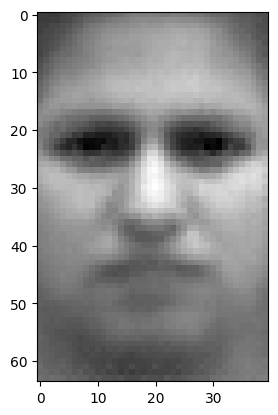

In [29]:
p = torch.tensor(data_locs[target].means_).type("torch.FloatTensor").to(config.device)
sample = model.submodel2.decoder(p)
sample = sample.cpu().detach().numpy() * 255
plt.imshow(sample[0, 0, :, :].astype("uint8"), cmap='gray')
matplotlib.image.imsave(f"data/selected/{target}.png", sample[0, 0, :, :] * 255, cmap='gray')

### Ambiguous aera sampling

In [13]:
from math import pi, atan2, asin, sqrt
import numpy as np
import cv2
import matplotlib
from torchvision.transforms import CenterCrop

In [21]:
model_name = "model/seed13_KL02(cafe).pt"  # "seed13_KL02(cafe) with weight of reconstryction as 0.6"
model = torch.load(config.saved_path + model_name)

In [22]:
_, _, test_loader = get_dataloaders(path='data/fer2013/fer2013.csv', desired_data=[3, 4, 6], bs=128)

In [23]:
def img_selector(model, dataloader, config, threshold):
    model.eval()

    for j, data in enumerate(dataloader): 
        base_images, labels = data
        base_images= base_images.to(config.device)
        (_, _), _, _, (rec, labels_emo_) = model(base_images)
    
        soft_value = torch.max(labels_emo_, dim=1, keepdim=False)
        idx = torch.nonzero(soft_value.values.cpu().detach()<threshold, as_tuple=False).numpy().squeeze().tolist()
        base_images = base_images.cpu().numpy()
        rec = rec.cpu().detach().numpy()
        if isinstance(idx, list):
            if len(idx) > 0:
                for i in idx:
                    matplotlib.image.imsave(f"data/selected/fer/{labels[i]}/{j}{i}.png", base_images[i][0, :, :] * 255, cmap='gray')
                    # matplotlib.image.imsave(f"data/selected/reconstruct/{labels[i]}/{j}{i}.png", rec[i][0, :, :] * 255, cmap='gray')
        elif isinstance(idx, int):
            matplotlib.image.imsave(f"data/selected/fer/{labels[idx]}/{j}{idx}.png", base_images[idx][0, :, :] * 255, cmap='gray')
            # matplotlib.image.imsave(f"data/selected/reconstruct/{labels[idx]}/{j}{idx}.png", rec[idx][0, :, :] * 255, cmap='gray')

In [110]:
amb_samples_0 = np.random.multivariate_normal(mean=(data_locs["Happy"].means_.squeeze() + data_locs["Sad"].means_.squeeze() + data_locs["Neutral"].means_.squeeze())/3, cov=np.identity(3), size=20)
amb_samples_1 = np.random.multivariate_normal(mean=(data_locs["Happy"].means_.squeeze() + data_locs["Sad"].means_.squeeze())/2, cov=np.identity(3), size=20)
amb_samples_2 = np.random.multivariate_normal(mean=(data_locs["Sad"].means_.squeeze() + data_locs["Neutral"].means_.squeeze())/2, cov=np.identity(3), size=20)
amb_samples_3 = np.random.multivariate_normal(mean=(data_locs["Happy"].means_.squeeze() + data_locs["Neutral"].means_.squeeze())/2, cov=np.identity(3), size=20)

In [111]:
amb_samples = np.concatenate((amb_samples_0, amb_samples_1, amb_samples_2, amb_samples_3), 0)
amb_samples

array([[ 1.95627977e+00, -6.56596133e-01, -4.57002586e-01],
       [ 1.17299297e-01, -6.17930851e-01,  6.24503311e-01],
       [ 6.03133842e-01,  1.78966534e-01, -1.70762781e+00],
       [ 1.84478888e+00, -1.12506133e+00,  5.51775856e-01],
       [ 8.15542135e-01,  1.81856868e+00,  2.01864819e-01],
       [ 3.00552073e+00, -6.94889613e-01, -1.21698221e+00],
       [ 2.44536660e+00,  1.05007623e+00,  1.90943737e+00],
       [ 1.60408720e+00,  2.96967237e-01, -1.08561415e+00],
       [ 1.25290604e+00,  6.57705247e-01, -2.63503941e+00],
       [ 2.64520493e+00,  1.82819903e-01,  8.67668943e-01],
       [ 1.42764285e+00,  1.36646570e+00,  3.01299068e-01],
       [ 1.48727276e+00,  1.49777770e+00, -1.42305266e+00],
       [ 1.24870968e+00,  1.76618055e+00,  7.39608455e-01],
       [ 1.29519678e+00, -1.31399024e+00, -8.81918837e-02],
       [-4.46234780e-01,  2.61520925e-01,  1.54898718e-01],
       [ 1.26124476e-01,  2.73865471e-01,  5.42700735e-01],
       [ 3.95372165e-01,  1.44536196e+00

In [112]:
model.eval()
sample = model.submodel2.decoder(torch.tensor(amb_samples).type("torch.FloatTensor").to(config.device))
images = sample.cpu().detach().numpy()[:, :, :, :]
print(len(images))
for i in range(len(images)):
    matplotlib.image.imsave(f"data/selected/chosen/{i}.png", images[i][0, :, :] * 255, cmap='gray')

80


In [24]:
img_selector(model, test_loader, config, threshold=0.4)

In [4]:
a = np.array([[ 1.95627977e+00, -6.56596133e-01, -4.57002586e-01],
       [ 1.17299297e-01, -6.17930851e-01,  6.24503311e-01],
       [ 6.03133842e-01,  1.78966534e-01, -1.70762781e+00],
       [ 1.84478888e+00, -1.12506133e+00,  5.51775856e-01],
       [ 8.15542135e-01,  1.81856868e+00,  2.01864819e-01],
       [ 3.00552073e+00, -6.94889613e-01, -1.21698221e+00],
       [ 2.44536660e+00,  1.05007623e+00,  1.90943737e+00],
       [ 1.60408720e+00,  2.96967237e-01, -1.08561415e+00],
       [ 1.25290604e+00,  6.57705247e-01, -2.63503941e+00],
       [ 2.64520493e+00,  1.82819903e-01,  8.67668943e-01],
       [ 1.42764285e+00,  1.36646570e+00,  3.01299068e-01],
       [ 1.48727276e+00,  1.49777770e+00, -1.42305266e+00],
       [ 1.24870968e+00,  1.76618055e+00,  7.39608455e-01],
       [ 1.29519678e+00, -1.31399024e+00, -8.81918837e-02],
       [-4.46234780e-01,  2.61520925e-01,  1.54898718e-01],
       [ 1.26124476e-01,  2.73865471e-01,  5.42700735e-01],
       [ 3.95372165e-01,  1.44536196e+00, -1.93849133e+00],
       [ 1.28649749e+00,  1.85443543e+00, -4.78358211e-01],
       [ 1.19053928e+00,  5.82370646e-01, -1.38067277e+00],
       [ 2.21201792e+00, -6.98658887e-01, -3.07671601e-01],
       [ 4.52449394e-01, -8.82379179e-01,  1.44024680e+00],
       [ 1.21545309e+00, -2.78985666e+00, -1.16100431e+00],
       [ 3.28638956e-01, -2.90956369e+00, -9.09817769e-02],
       [ 1.39495269e+00,  1.59066260e-01, -1.08025593e+00],
       [ 1.81482024e+00,  8.27160294e-01,  3.09894115e-01],
       [ 2.89973750e+00, -2.56747397e+00,  5.03559084e-01],
       [ 2.26955830e+00, -1.03905951e+00, -4.51882229e-01],
       [ 1.44321438e+00, -1.28060882e+00, -2.48398099e-01],
       [ 2.07233953e+00,  9.14345892e-01, -8.15721686e-01],
       [ 5.95531354e-01, -3.20033968e-01, -2.57437591e-01],
       [ 2.98848611e+00, -5.76025017e-01, -3.10098000e-01],
       [ 4.54313020e-01, -1.67057487e-01,  3.57495274e-01],
       [ 2.26565438e+00, -4.97144797e-01, -1.36227521e+00],
       [ 2.05422972e+00, -8.32909186e-01,  1.75155913e+00],
       [ 1.57203006e+00,  3.08249952e-01, -2.12230019e+00],
       [ 1.79295917e+00,  8.93024856e-01, -4.92964470e-01],
       [ 6.75833026e-01,  1.83793884e-01,  1.67504920e+00],
       [ 9.30729746e-01, -1.10408484e+00, -1.30560961e+00],
       [-5.83692947e-01, -5.52154831e-01, -5.07877785e-01],
       [ 2.20420157e+00,  5.84319672e-02, -8.08022343e-01],
       [ 1.05289744e+00,  1.61090863e+00,  7.34545800e-01],
       [ 1.74731515e+00,  2.04635932e-01,  1.82417626e+00],
       [-3.87358204e-01,  2.45468181e+00, -1.08499777e+00],
       [-6.21780517e-01,  2.18751845e+00,  5.81445268e-01],
       [ 2.82828418e-01,  8.88123973e-01, -1.80638484e+00],
       [-1.89124466e-02,  2.48598497e+00,  1.71832036e-01],
       [ 8.26598001e-01,  8.80180567e-01, -5.45243811e-01],
       [ 3.41529965e-01,  3.15669535e+00, -1.20104522e-01],
       [ 1.94844991e+00,  2.98354641e+00,  2.93599835e-01],
       [ 1.25950715e+00,  2.62538278e+00,  7.67871206e-01],
       [-8.01469866e-01,  1.75429601e+00,  1.05819625e+00],
       [-5.83279139e-01,  1.95542000e+00,  2.34446979e-01],
       [ 9.04811646e-01,  7.57839059e-01,  2.71048504e+00],
       [-5.85803398e-01,  1.40003094e+00,  3.18747716e-01],
       [ 3.67314170e-01,  8.64432636e-01,  2.87074134e-01],
       [ 6.12763139e-01,  2.68510552e+00,  2.72033682e-01],
       [ 1.26610825e+00,  2.50489250e+00, -5.31704642e-01],
       [-1.14976346e+00,  2.54290532e+00,  6.06832501e-01],
       [ 1.55317179e+00,  2.93352310e+00, -4.05066811e-01],
       [ 7.31004911e-01,  2.85980852e+00, -1.24881110e+00],
       [ 1.60411954e+00,  1.85041177e+00, -2.21736383e+00],
       [ 3.08543373e+00,  9.68107730e-01, -1.96312251e+00],
       [ 7.53161332e-01, -4.34461223e-02, -9.82001863e-01],
       [ 9.55080632e-01, -1.74758298e-01, -3.33826582e+00],
       [ 1.95581408e+00, -4.52173382e-01, -1.80429993e+00],
       [ 3.55089395e+00, -7.29846906e-01, -2.03461332e+00],
       [ 6.26739419e-01, -3.48102949e-02,  1.11543598e-01],
       [ 2.30570012e+00,  9.30281698e-01, -5.53059635e-01],
       [ 2.86662529e+00, -1.26165311e+00,  3.45942664e-02],
       [ 3.44958986e+00, -1.11971525e+00, -1.59860236e+00],
       [ 6.68818318e-01, -3.24196587e+00, -2.45116477e+00],
       [ 2.59821048e+00,  9.53317426e-01, -2.22269200e+00],
       [ 3.02506480e+00, -4.91816902e-01, -4.09014015e+00],
       [ 3.85576526e+00, -1.53060350e+00, -2.92749604e+00],
       [ 2.28687481e+00, -9.56031077e-01, -1.17635753e+00],
       [ 2.15078252e+00, -4.79014486e-01, -2.05354604e+00],
       [ 3.46982678e+00, -9.69044098e-01, -1.85560008e+00],
       [ 3.99856630e+00, -7.58263114e-01,  9.87868185e-02],
       [ 1.00795789e+00, -3.76148567e-03, -8.84742288e-01],
       [ 2.82914104e+00,  1.62167557e+00, -3.61110185e-01]])

In [6]:
np.save('probe.npy', a)

# PCA on cafe

In [5]:
import numpy as np
from PIL import Image
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def load_and_flatten_image(filename):
    with Image.open(filename) as img:
        return np.array(img).flatten()

# Assuming 'image_filenames' is a list of your image file paths
data = np.array([load_and_flatten_image(os.path.join(config.data_path, fname)) for fname in os.listdir(config.data_path) if os.path.splitext(fname)[-1] == '.jpg'])

In [17]:
data

array([[112, 110, 114, ..., 113, 116, 116],
       [231, 174, 107, ...,  94,  94,  94],
       [ 94, 100, 108, ..., 169, 175, 179],
       ...,
       [ 81,  78,  79, ..., 134, 103,  62],
       [ 83,  77,  78, ...,  98,  88, 107],
       [ 80,  80,  80, ...,  99,  90, 110]], dtype=uint8)

In [41]:
scaler = StandardScaler()
scaler.fit(data)
data_std = scaler.transform(data)

In [42]:
data_std

array([[ 1.00765921,  0.97068781,  1.12947895, ..., -0.30995322,
        -0.20252765, -0.15227808],
       [ 4.81626099,  3.07733065,  0.88939232, ..., -0.81813721,
        -0.72787571, -0.63949413],
       [ 0.43156819,  0.64152486,  0.92369041, ...,  1.1878522 ,
         1.20636034,  1.24293151],
       ...,
       [ 0.01550245, -0.08263361, -0.07095417, ...,  0.25172381,
        -0.5129606 , -1.34817202],
       [ 0.07951256, -0.11554991, -0.10525226, ..., -0.71115111,
        -0.87115246, -0.35159374],
       [-0.01650261, -0.01680103, -0.03665608, ..., -0.68440458,
        -0.82339354, -0.28515519]])

In [43]:
n_components = 157

pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(data_std)

In [20]:
reduced_data

array([[-1.80132298e+01, -1.83191966e+00,  1.61709256e+01, ...,
         8.44735821e-02, -5.68129286e-01, -5.96935354e-01],
       [-1.11490478e+01, -1.08395536e+01,  1.35004255e+01, ...,
        -1.79078884e+00, -2.63003232e-01, -8.74961712e-01],
       [ 4.08528928e+01,  7.16900631e+00,  2.86108448e+01, ...,
        -8.25618961e-02,  8.52352731e-01,  3.82104742e-01],
       ...,
       [ 3.57548757e+01,  8.85141100e+00,  1.67901008e+01, ...,
         6.78407546e-03,  1.32095697e-01,  1.54178222e+00],
       [ 3.25172798e+01,  1.34820619e+01,  1.49604932e+01, ...,
        -2.29645358e+00,  7.39228055e-02,  4.82686588e-01],
       [ 4.05702522e+01,  1.52624219e+01,  1.94131639e+01, ...,
         1.02056563e+00,  8.39114759e-01,  1.22577222e+00]])

In [81]:
np.ptp(reduced_data, 0)

array([87.27151431, 83.76815371, 66.61492836, 63.97852507, 62.61947265,
       51.98050434, 50.01679304, 53.96466985, 40.16724169, 44.82944812,
       46.71134649, 45.78643793, 44.25848314, 35.70750017, 42.79834223,
       41.52855287, 37.16981666, 31.25182811, 31.97705003, 31.04929766,
       30.35494051, 34.2336544 , 31.53420207, 29.09638892, 27.99486892,
       31.64061188, 27.84881508, 27.20461082, 26.64742407, 27.24001771,
       26.46948992, 23.51436445, 23.07834032, 24.16666067, 23.51672653,
       20.60292896, 22.36876956, 22.1256194 , 20.10044994, 19.81020745,
       25.11008958, 19.26594274, 16.1196361 , 18.32722623, 19.67458029,
       22.09153196, 18.89682906, 19.42299298, 22.40600297, 18.83045408,
       17.42043719, 15.65240832, 14.97349392, 17.43550164, 18.61779518,
       19.14555327, 14.75947991, 14.25891156, 13.81712633, 11.92555538,
       14.50560324, 18.93294601, 14.41556599, 13.71632302, 17.19340338,
       13.40441814, 13.65109095, 14.99065746, 12.33782324, 14.83

In [48]:
low = np.std(reduced_data, 0) * (-1)
high = np.std(reduced_data, 0)
np.save("pca_range.npy", high)
high
# reconstruction = scaler.inverse_transform(pca.inverse_transform(samples))
# plt.imshow(reconstruction.reshape((64, 40)), cmap='gray')

array([20.78518748, 15.15651549, 12.56640211, 11.50741533, 10.99054853,
        9.35422339,  8.61791543,  8.52059125,  7.61111425,  7.4589819 ,
        7.26469477,  7.13575988,  6.66074564,  6.47285601,  6.04775561,
        5.70586743,  5.61321059,  5.20242317,  5.06146546,  4.94670131,
        4.90080599,  4.7854016 ,  4.64725815,  4.49604756,  4.22594383,
        4.17280336,  4.09944533,  4.01150217,  3.98642618,  3.89060851,
        3.85792393,  3.65618276,  3.6096106 ,  3.56562061,  3.37214428,
        3.35537579,  3.25159995,  3.20024747,  3.07469799,  3.01983231,
        2.9900644 ,  2.91687927,  2.86610988,  2.85179483,  2.78969229,
        2.73705162,  2.67535835,  2.60912227,  2.57992523,  2.54272708,
        2.49012146,  2.44027672,  2.42153648,  2.3785786 ,  2.30391504,
        2.27334954,  2.26063485,  2.24603584,  2.22899841,  2.19449472,
        2.17018451,  2.11836074,  2.10499952,  2.09130225,  2.06322045,
        2.04275522,  2.00475097,  1.99591353,  1.97495422,  1.94

In [66]:
samples = np.random.uniform(low, high, (1, len(low)))
samples

array([[ 9.39874891, 11.01357281, -7.74012906, -4.16609255,  5.20287654,
         8.70968957,  0.34540241, -5.71240499, -4.77365866, -3.58043848,
        -1.32110869,  5.11448125,  1.84470219,  1.79407481, -0.49470154,
         1.72099126, -3.45374606, -0.39112566, -1.08690706,  4.71374849,
        -1.68071466, -4.28244559,  2.06323472,  3.52483953,  1.68564009,
        -0.98027773, -3.4232242 , -2.92758148,  1.65556735,  3.47946405,
         1.88052459, -2.6038981 ,  2.51148133, -2.39322666, -3.23286802,
         1.04450808,  0.89936108,  2.36079758,  1.70221974, -1.76255784,
        -2.05505076, -0.36575733, -2.35983195, -0.9085142 ,  2.55902138,
         1.58081531, -0.50126697,  0.54318235,  0.94894694,  1.97058084,
         0.21628895,  1.93897623, -0.62051559, -1.38063101, -0.62572655,
        -0.32201571,  0.73945287, -1.84982115, -0.66526055,  1.67241206,
        -2.10829688, -0.2143068 , -1.57363346,  0.9284336 ,  0.96570617,
        -0.5575164 , -0.02712322, -0.24855443, -1.3

157 0.9500502983601815
0.9500502983601815


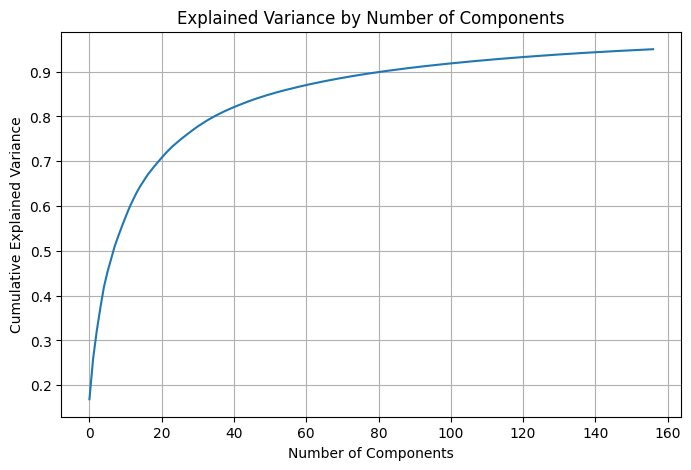

In [46]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] >= 0.95:
        print(i+1, cumulative_explained_variance[i])
        break
print(cumulative_explained_variance[-1])
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

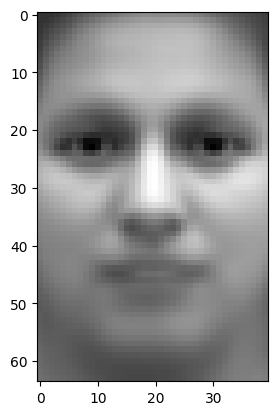

In [17]:
reconstructed_data = scaler.inverse_transform(pca.inverse_transform(np.zeros((1, 157)))).reshape((64, 40))
plt.imshow(reconstructed_data, cmap='gray')

IndexError: index 5 is out of bounds for axis 0 with size 1

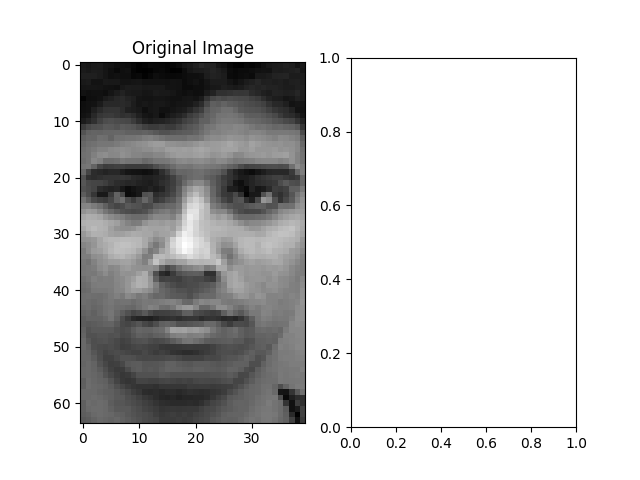

In [47]:
check = 5
fig, axes = plt.subplots(1, 2)
axes[0].imshow(data[check].reshape((64, 40)), cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(reconstructed_data[check].reshape((64, 40)), cmap='gray')
axes[1].set_title('Reconstructed Image after PCA')
plt.show()

In [86]:
from joblib import dump

dump(pca, 'pca_157.joblib')

['pca_157.joblib']

In [90]:
dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [6]:
from joblib import load

# Load the model from the file
pca = load('pca_157.joblib')
scaler = load('scaler.joblib')

# Use the loaded model for transformation/prediction
# transformed_data = pca.transform(new_data)

In [7]:
reduced_data = pca.transform(scaler.transform(data))

In [8]:
reduced_data

array([[-1.80132298e+01, -1.83191966e+00,  1.61709256e+01, ...,
         8.44735821e-02, -5.68129286e-01, -5.96935354e-01],
       [-1.11490478e+01, -1.08395536e+01,  1.35004255e+01, ...,
        -1.79078884e+00, -2.63003232e-01, -8.74961712e-01],
       [ 4.08528928e+01,  7.16900631e+00,  2.86108448e+01, ...,
        -8.25618961e-02,  8.52352731e-01,  3.82104742e-01],
       ...,
       [ 3.57548757e+01,  8.85141100e+00,  1.67901008e+01, ...,
         6.78407546e-03,  1.32095697e-01,  1.54178222e+00],
       [ 3.25172798e+01,  1.34820619e+01,  1.49604932e+01, ...,
        -2.29645358e+00,  7.39228055e-02,  4.82686588e-01],
       [ 4.05702522e+01,  1.52624219e+01,  1.94131639e+01, ...,
         1.02056563e+00,  8.39114759e-01,  1.22577222e+00]])

In [49]:
import requests

In [67]:
a = requests.post('http://50.116.63.93:5000', json={"loc": samples.tolist()}).text

In [ ]:
# flow based model

In [26]:
# Import required packages
import torch
import torchvision as tv
import numpy as np
import normflows as nf
from matplotlib import pyplot as plt
from tqdm import tqdm

In [68]:
# Define flows
L = 3
K = 10
torch.manual_seed(0)

input_shape = (1, 64, 40)
n_dims = np.prod(input_shape)
channels = 1
hidden_channels = 64
split_mode = 'channel'
scale = True
num_classes = 7

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i), 
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L, 
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.ClassCondDiagGaussian(latent_shape, num_classes)]


# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges)
# print(model)

In [69]:
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [40]:
# Prepare training data
# batch_size = 128

# transform = tv.transforms.Compose([tv.transforms.ToTensor(), nf.utils.Scale(255. / 256.), nf.utils.Jitter(1 / 256.)])
# train_data = tv.datasets.CIFAR10('datasets/', train=True,
#                                  download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
#                                            drop_last=True)

# test_data = tv.datasets.CIFAR10('datasets/', train=False,
#                                 download=True, transform=transform)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# train_iter = iter(train_loader)

Files already downloaded and verified
Files already downloaded and verified


In [70]:
max_iter = 500

loss_hist = np.array([])

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

for i in tqdm(range(max_iter)):
    for data in train_loader:
        x, _, y, _ = data
        x = x*255
        optimizer.zero_grad()
        loss = model.forward_kld(x.to(device), y.to(device))
        
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()

        loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [25:23<00:00,  3.05s/it]


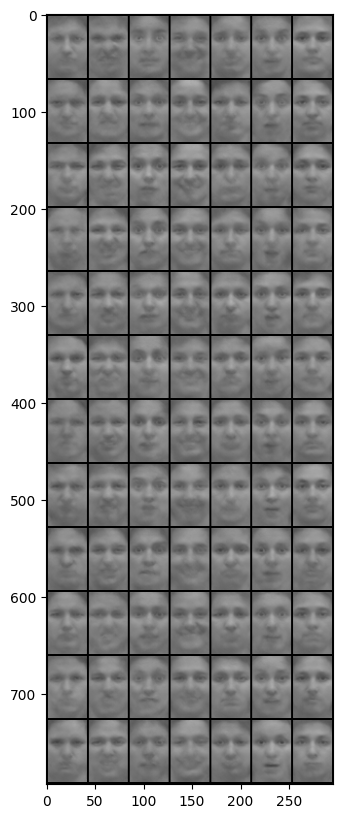

In [71]:
num_sample = 12

with torch.no_grad():
    y = torch.arange(num_classes).repeat(num_sample).to(device)
    x, _ = model.sample(y=y, temperature=0.5)
    x_ = torch.clamp(x, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(tv.utils.make_grid(x_, nrow=num_classes).cpu().numpy(), (1, 2, 0)))
    plt.show()